In [1]:
# Importing libraries.
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Reading the data.
holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', header = 0)
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', header = 0)
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv', header = 0)
trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', header = 0)
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', header = 0)
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', header = 0)

# converting date column in each dataset to DateTime format.
holidays['date'] = pd.to_datetime(holidays['date'], format = "%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format = "%Y-%m-%d")
trans['date'] = pd.to_datetime(trans['date'], format = "%Y-%m-%d")
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

In [3]:
transD = holidays.transferred.value_counts() # geting the number of transferred holidays.
typeD = holidays.type.value_counts() # geting the number of each holiday type.
localeD = holidays.locale.value_counts() # geting the number of each holiday locale.

# plotting the data.
fig = make_subplots(rows=2, cols=3, specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"}],
                          [{"colspan": 3},None,None] ],
                    vertical_spacing=0.2, horizontal_spacing=0.1,
                    subplot_titles=('Percentage of Transferred Holidays', 'Percentage of Holidays\' Typs',
                                    "Percentage of Holidays\' Lacale States" ,'Holidays\' Names'))

fig.append_trace(go.Pie(labels=transD.index, values=transD),
              row=1, col=1)

fig.add_trace(go.Pie(labels=typeD.index, values=typeD),
              row=1, col=2)

fig.add_trace(go.Pie(labels=localeD.index, values=localeD),
              row=1, col=3)

fig.add_trace(go.Histogram(x=holidays.locale_name),
              row=2, col=1)

fig.update_layout(height=800,showlegend=False)
fig.show()

In [4]:
# getting only what we need from holidays' data.
holidays = holidays[holidays.transferred == False][['date','type','locale','locale_name']][(holidays.date >= '2013-01-01')&(holidays.date <= '2017-08-31')]
holidays

,date,type,locale,locale_name
41,2013-01-01,Holiday,National,Ecuador
42,2013-01-05,Work Day,National,Ecuador
43,2013-01-12,Work Day,National,Ecuador
44,2013-02-11,Holiday,National,Ecuador
45,2013-02-12,Holiday,National,Ecuador
...,...,...,...,...
322,2017-07-25,Additional,Local,Guayaquil
323,2017-08-05,Holiday,Local,Esmeraldas
325,2017-08-11,Transfer,National,Ecuador
326,2017-08-15,Holiday,Local,Riobamba


In [5]:
# plotting oil data.
fig = go.Figure([go.Scatter(x=oil['date'], y=oil['dcoilwtico'],marker=dict(color= '#783242'))])
fig.show()

In [6]:
oil = oil.set_index('date').fillna(method = 'bfill')
oil_moving_average = oil.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08)
fig.add_trace(go.Scatter(x=oil.index, y=oil['dcoilwtico'], mode='lines',
                     marker=dict(color= '#783242'), name='365-Day Oil Moving Average'))
fig.add_trace(go.Scatter(x=oil_moving_average.index,y=oil_moving_average.dcoilwtico,mode='lines',name='Trend'))
fig.show()

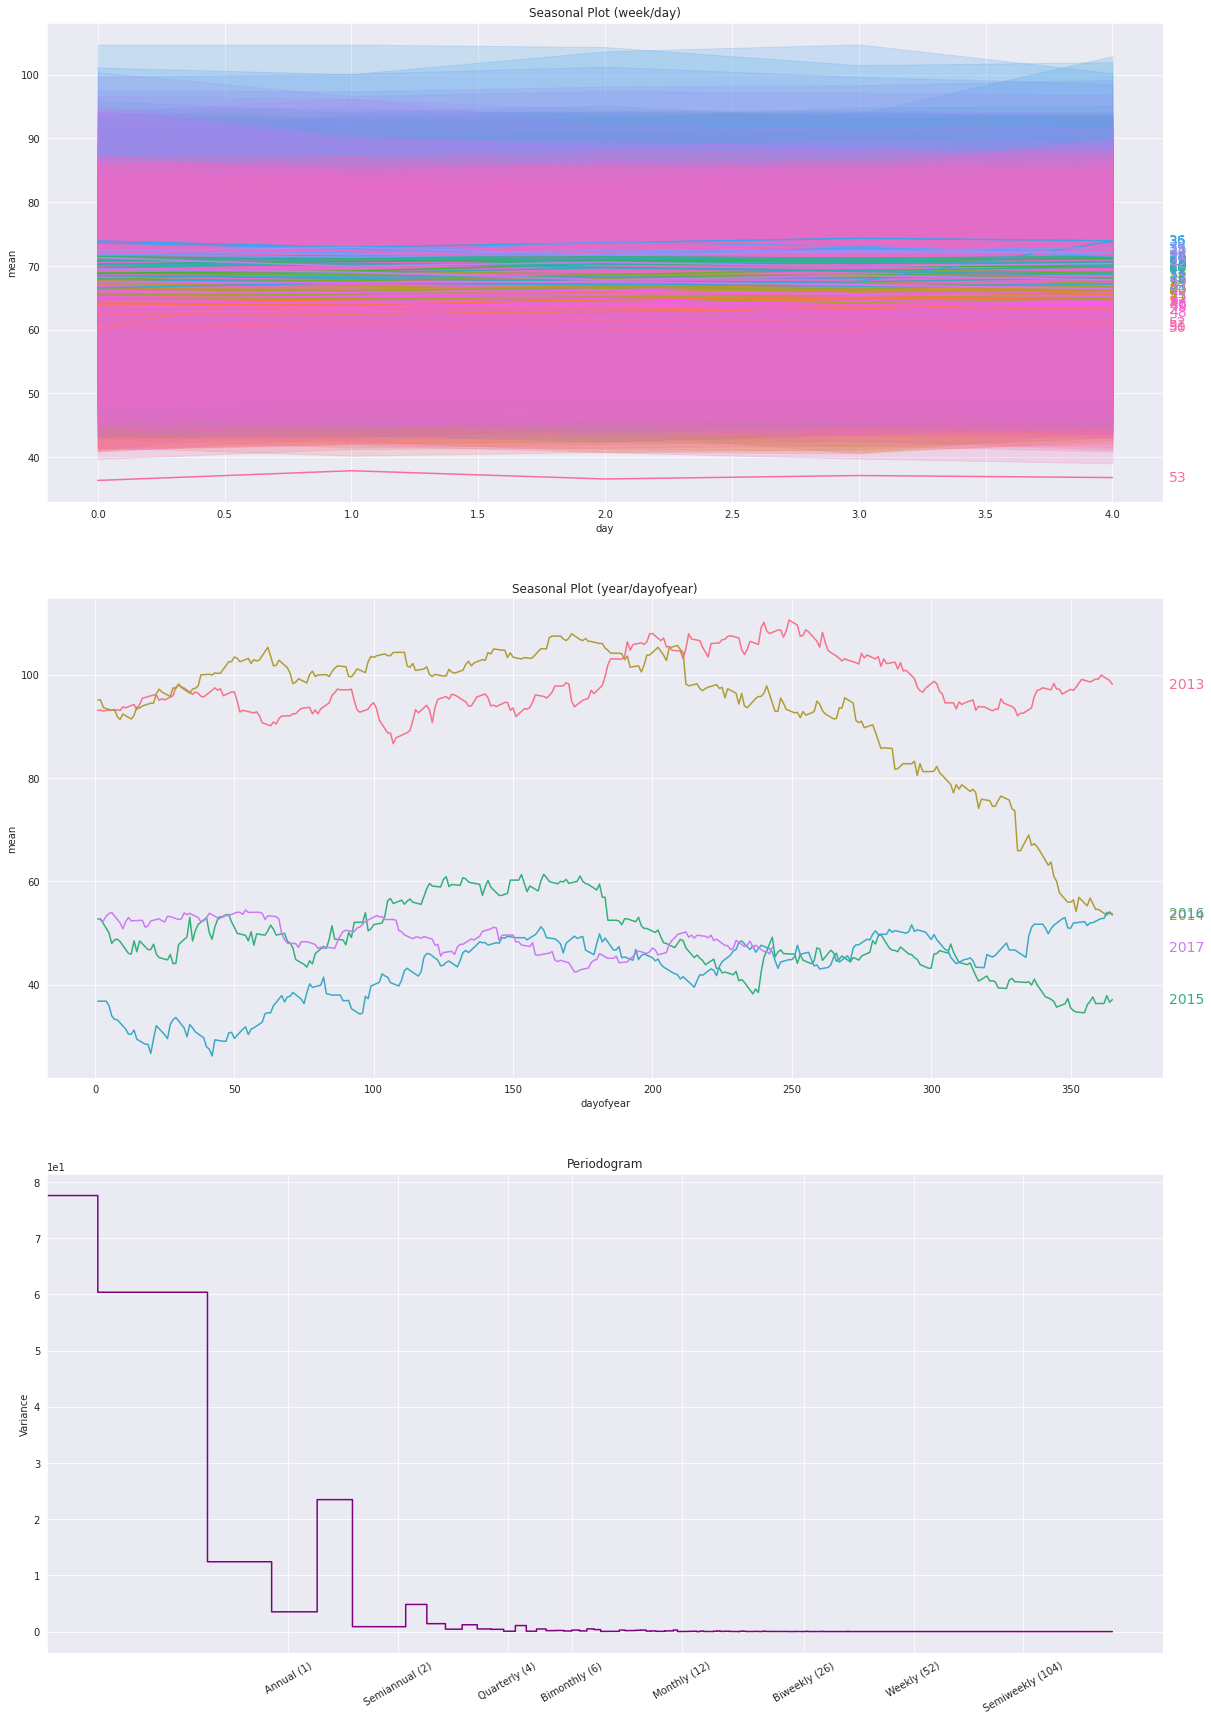

In [7]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def seasonality(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d")
    df_grouped.index = df_grouped['date'] 
    df_grouped = df_grouped.drop(columns=['date'])
    df_grouped.index.freq = freq # manually set the frequency of the index
    
    X = df_grouped.copy()
    X.index = pd.to_datetime(X.index, format = "%Y-%m-%d") 
    X.index.freq = freq 
    # days within a week
    X["day"] = X.index.dayofweek   # the x-axis (freq)
    X["week"] = pd.Int64Index(X.index.isocalendar().week)  # the seasonal period (period)
    # days within a year
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 30))
    seasonal_plot(X, y='mean', period="week", freq="day", ax=ax0)
    seasonal_plot(X, y='mean', period="year", freq="dayofyear", ax=ax1)
    X_new = (X['mean'].copy()).dropna()
    plot_periodogram(X_new, ax=ax2)
    
seasonality(oil.reset_index(), 'date', 'D', 'dcoilwtico')

In [8]:
# plotting transactions data.
trans_date = trans.drop('store_nbr',axis=1).groupby('date').mean()
store_nbr_trans = trans.drop('date',axis=1).groupby('store_nbr').mean()
trans_date_moving_average = trans_date.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.09,subplot_titles=('Transactions Moving Average','Average Store Transactions'))
fig.add_trace(go.Scatter(x=trans_date.index, y=trans_date['transactions'], mode='lines',
              marker=dict(color= '#1fdbb9')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=trans_date_moving_average.index,y=trans_date_moving_average.transactions,mode='lines',marker=dict(color= '#067863'),name='Trend'),
              row=1, col=1)
fig.add_trace(go.Bar(x=store_nbr_trans.index, y=store_nbr_trans.transactions),
              row=2, col=1)
fig.update_layout(height=800,showlegend=False)
fig.show()

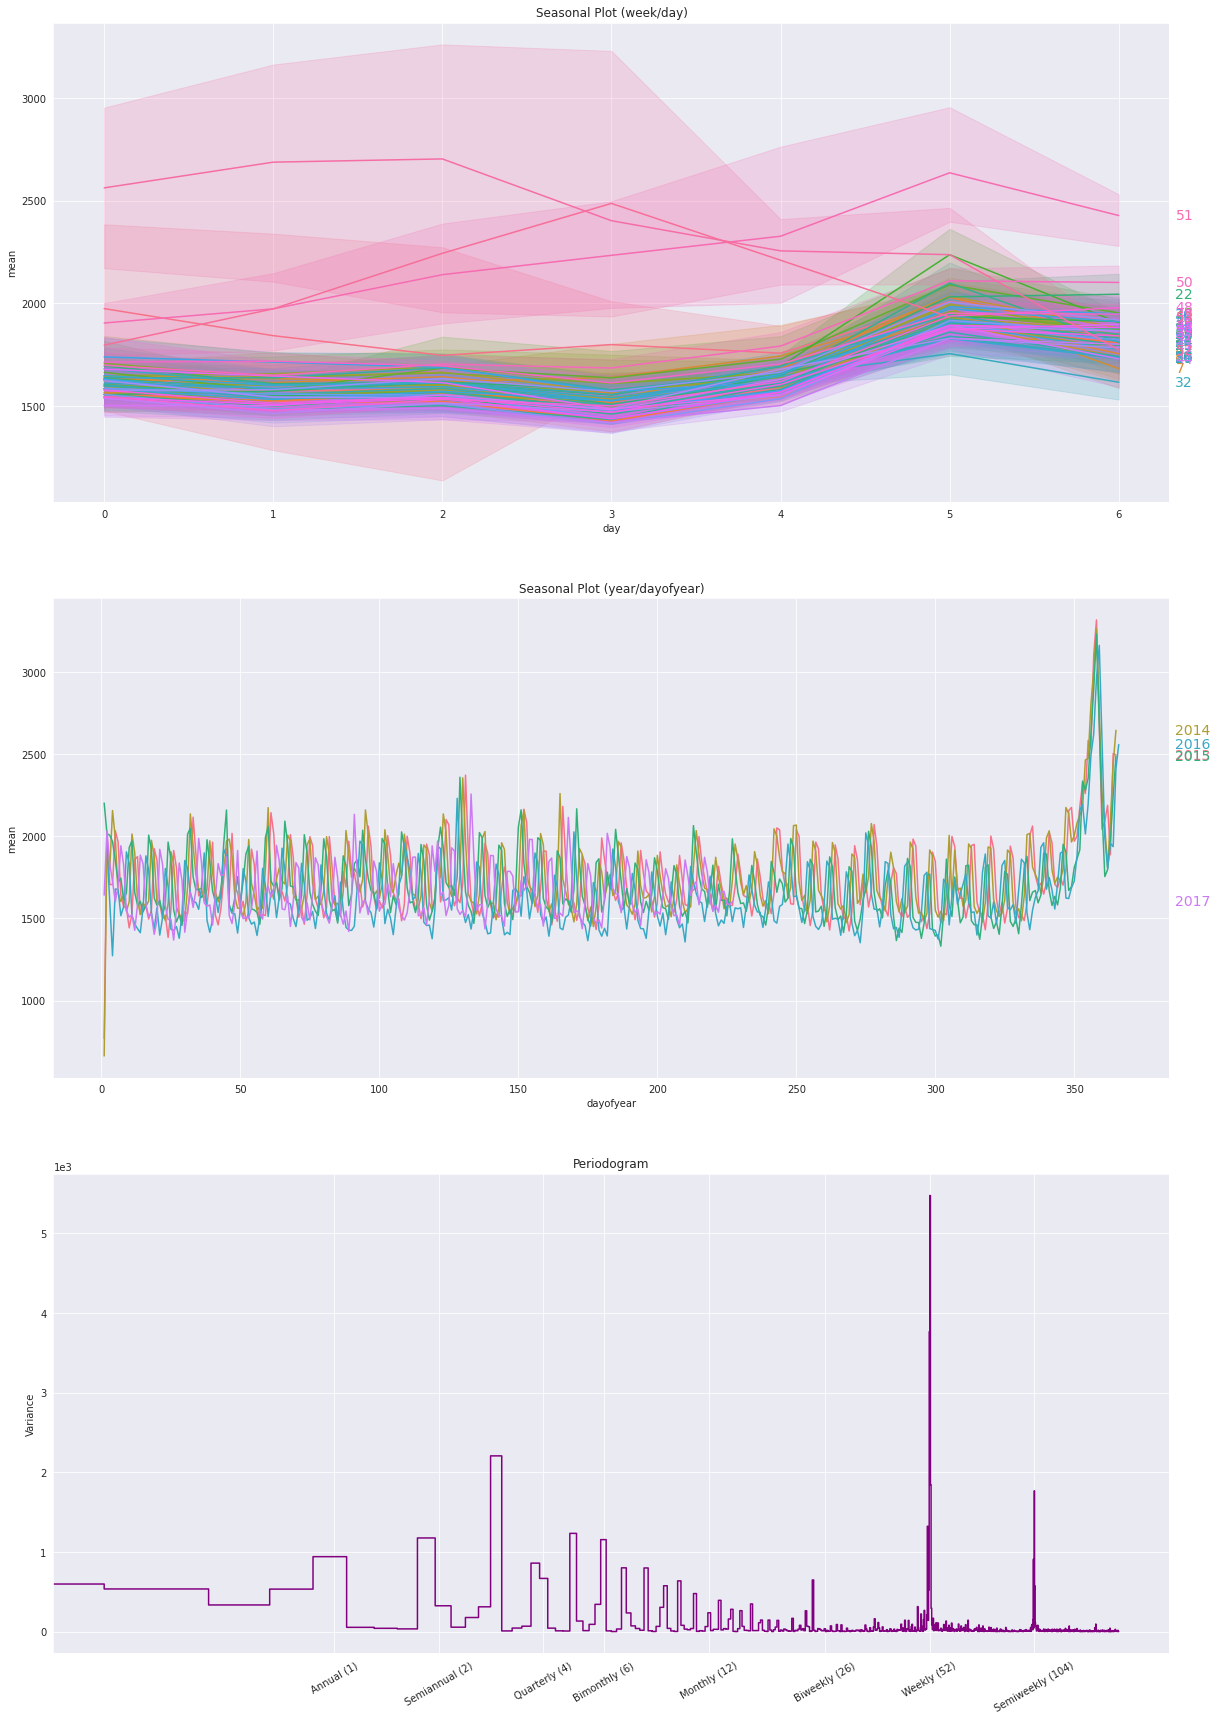

In [9]:
# checking the seasonality in transactions data.
seasonality(trans, 'date', 'D', 'transactions')

# Train Data

In [10]:
train_modi = train.drop('id',axis=1) # droping the ID column.

# identifying holidays dates.
train_modi['holiday'] = 0
for date in holidays.date:
    train_modi['holiday'][train_modi.date == date] = 1
train_modi = pd.merge(train_modi, oil, how='left', on = 'date') # joining oil data.
train_modi = pd.merge(train_modi, trans, how='left', on = ['date','store_nbr']) # joining transactions data.
train_modi.drop(['store_nbr','family'],axis=1,inplace=True) # droping unnecessary columns.
train_modi = train_modi.groupby('date').mean() # grouping by date.
train_modi.fillna(method = 'bfill',inplace=True) # filling nan values.
train_modi

,sales,onpromotion,holiday,dcoilwtico,transactions
date,,,,,
2013-01-01,1.41,0.00,1.00,93.14,770.00
2013-01-02,278.39,0.00,0.00,93.14,2026.41
2013-01-03,202.84,0.00,0.00,92.97,1706.61
2013-01-04,198.91,0.00,0.00,93.12,1706.39
2013-01-05,267.87,0.00,1.00,93.20,2034.20
...,...,...,...,...,...
2017-08-11,463.73,7.96,1.00,48.81,1658.35
2017-08-12,444.80,4.66,0.00,47.59,1665.31
2017-08-13,485.77,5.21,0.00,47.59,1592.46


In [11]:
train_sales = train_modi.sales # sales data.
store_sales = train[['store_nbr','sales']].groupby('store_nbr').mean() # getting the average sales for each store.
family_sales = train[['family','sales']].groupby('family').mean() # getting the average sales for each family.
family_onpromotions = train[['family','onpromotion']].groupby('family').mean() #  getting the average promotion for each family.
# plotting.
train_sales_moving_average = train_sales.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()
fig = make_subplots(rows=4, cols=1, vertical_spacing=0.09,
                    subplot_titles=('Sales Moving Average', 'Store Sales',
                                    "Family Sales" ,'Family Onpromotions'))
fig.add_trace(go.Scatter(x=train_sales.index, y=train_sales, mode='lines',
              marker=dict(color= '#dbd623')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=train_sales_moving_average.index,y=train_sales_moving_average,mode='lines',marker=dict(color= '#eb8328'),name='Trend'),
              row=1, col=1)
fig.add_trace(go.Bar(x=store_sales.index, y=store_sales.sales),
              row=2, col=1)
fig.add_trace(go.Bar(x=family_sales.index, y=family_sales.sales),
              row=3, col=1)
fig.add_trace(go.Bar(x=family_onpromotions.index, y=family_onpromotions.onpromotion),
              row=4, col=1)
fig.update_layout(height=1750,showlegend=False)
fig.show()

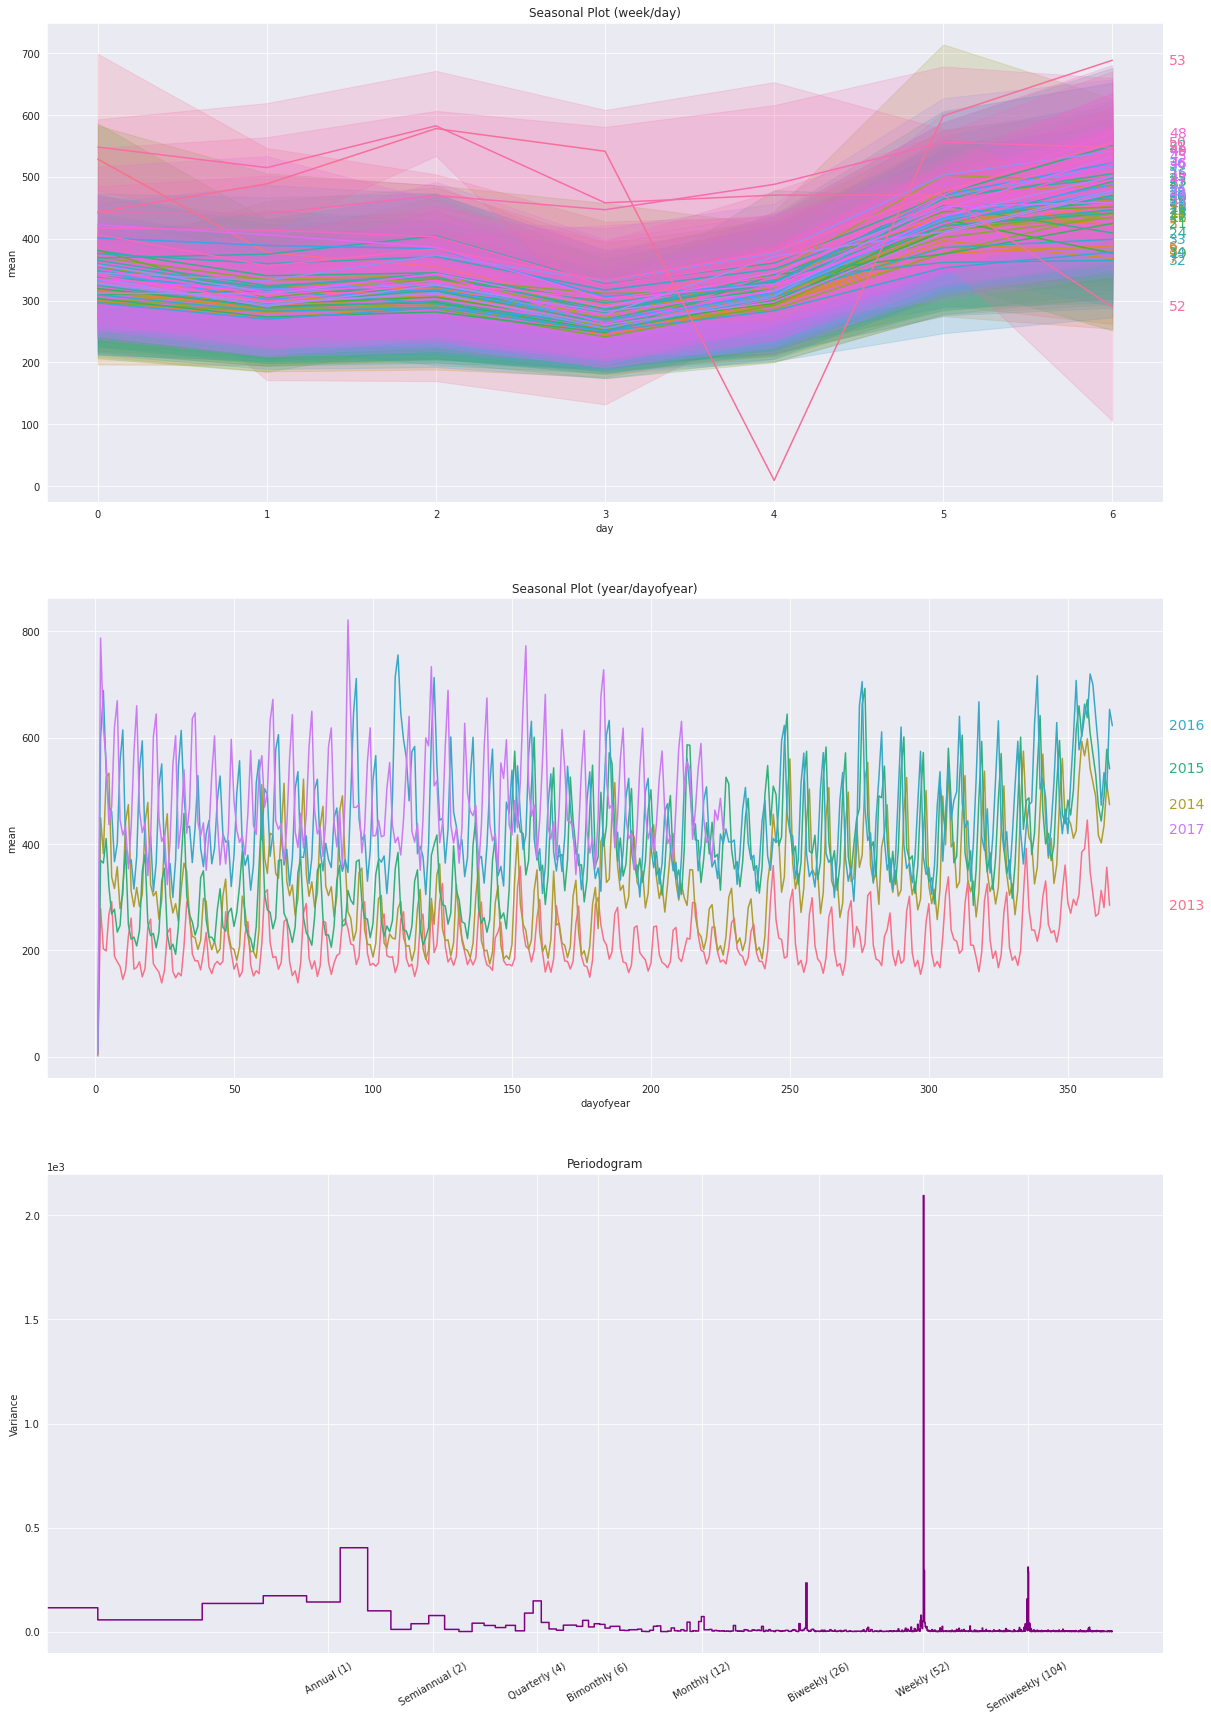

In [12]:
# checking the seasonality in train data.
seasonality(train_modi.reset_index(), 'date', 'D', 'sales')

## Train Data Correlations

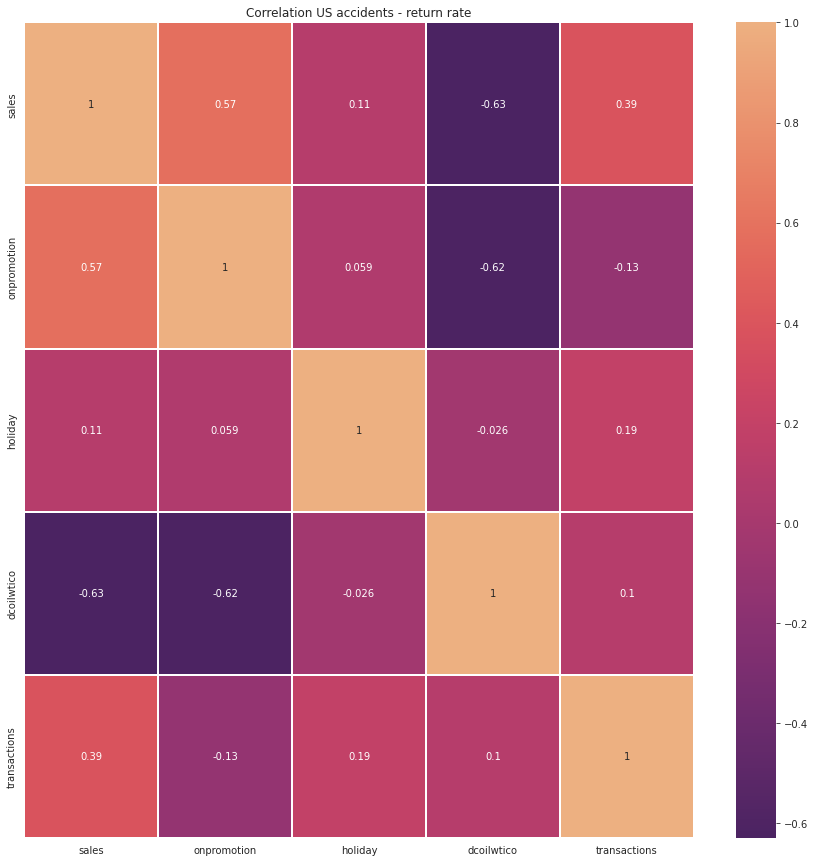

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_modi.corr(), annot=True, cmap="flare_r", linewidths=0.1, annot_kws={"fontsize":10})
plt.title("Correlation US accidents - return rate");

# Modeling

In [14]:
full_data = pd.concat([train, test]).drop('id',axis=1)

full_data['holiday'] = 0
for date in holidays.date:
    full_data['holiday'][full_data.date == date] = 1
    
full_data = pd.merge(full_data, oil, how='left', on = 'date')

full_data['year'] = full_data.date.dt.year
full_data['month'] = full_data.date.dt.month
full_data['monthday'] = full_data.date.dt.day
full_data['weekday'] = full_data.date.dt.dayofweek

train = full_data.iloc[:len(train),:] 
test = full_data.iloc[len(train):,:]

In [15]:
train

,date,store_nbr,family,sales,onpromotion,holiday,dcoilwtico,year,month,monthday,weekday
0,2013-01-01,1,AUTOMOTIVE,0.00,0,1,93.14,2013,1,1,1
1,2013-01-01,1,BABY CARE,0.00,0,1,93.14,2013,1,1,1
2,2013-01-01,1,BEAUTY,0.00,0,1,93.14,2013,1,1,1
3,2013-01-01,1,BEVERAGES,0.00,0,1,93.14,2013,1,1,1
4,2013-01-01,1,BOOKS,0.00,0,1,93.14,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.13,0,1,47.57,2017,8,15,1
3000884,2017-08-15,9,PREPARED FOODS,154.55,1,1,47.57,2017,8,15,1
3000885,2017-08-15,9,PRODUCE,2419.73,148,1,47.57,2017,8,15,1
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,1,47.57,2017,8,15,1


In [16]:
test

,date,store_nbr,family,sales,onpromotion,holiday,dcoilwtico,year,month,monthday,weekday
3000888,2017-08-16,1,AUTOMOTIVE,NaN,0,0,46.80,2017,8,16,2
3000889,2017-08-16,1,BABY CARE,NaN,0,0,46.80,2017,8,16,2
3000890,2017-08-16,1,BEAUTY,NaN,2,0,46.80,2017,8,16,2
3000891,2017-08-16,1,BEVERAGES,NaN,20,0,46.80,2017,8,16,2
3000892,2017-08-16,1,BOOKS,NaN,0,0,46.80,2017,8,16,2
...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,0,47.26,2017,8,31,3
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,0,47.26,2017,8,31,3
3029397,2017-08-31,9,PRODUCE,NaN,1,0,47.26,2017,8,31,3
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,0,47.26,2017,8,31,3


In [17]:
train.dropna(axis=0,subset = ['sales'], inplace = True) # droping null values from target.
X_train_full = train.drop(['sales'], axis =1)
y_train_full = train.sales
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,test_size=0.2, random_state=42) # spliting the data.

In [18]:
# A categorical transformer.
cat_trans = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'))
])
# A preprocessor that combines the two previous transformers.
preprocessor = ColumnTransformer(transformers = [
    ('cat', cat_trans, ['family'])
],
    remainder = "drop")
X_train_trans = preprocessor.fit_transform(X_train).toarray()
X_valid_trans = preprocessor.transform(X_valid).toarray()

## Training Model

In [19]:
LR_model = LinearRegression() # creating linear regression model.

LR_model.fit(X_train_trans, y_train) # fitting the model with the training data.
preds_LR = LR_model.predict(X_valid_trans) # predict the target.

mean_absolute_error(y_valid, preds_LR) # geting the mean absolute error for predictions.

240.39347467683726

In [20]:
# preprocessing whole train and test data.
train_trans = preprocessor.fit_transform(X_train_full).toarray()
test_trans = preprocessor.transform(test.drop('sales',axis=1)).toarray()

In [21]:
LR_model = LinearRegression()
LR_model.fit(train_trans, y_train_full)
preds_LR = LR_model.predict(test_trans)

In [22]:
submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv') # reading the sample_submission dataset.
submission['sales'] = preds_LR # assigning sales to our predictions.
submission

,id,sales
0,3000888,5.89
1,3000889,0.11
2,3000890,3.55
3,3000891,2386.26
4,3000892,0.14
...,...,...
28507,3029395,350.71
28508,3029396,96.80
28509,3029397,1349.30
28510,3029398,3.34


In [23]:
submission.to_csv('submission.csv', index=False, header=True)